### Introduction
A bank conducted telephone marketing campaigns and interested in identifying factors that affect client responses to new term deposit offerings. The goal of this assignment is to predict the binary response variable by three binary explanatory variables relating to client banking history: default, housing, and loan. We need to determine if a client has subscribed to a term deposit with Yes/No answers. We need to explore the data, employ the logistic regression and naïve Bayes classification methods. Then we need to validate which models were most successful at predicting customer response behavior. If the classifier predicts well, we can use to pre-screen customer data for any future marketing campaign by focusing resources on the individuals most likely to make a purchase.

### System & Data Setup

In [1]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Execute the code line by line in jupyter-notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from pathlib import Path
import urllib.parse
import random

In [2]:
# initial work with the smaller data set
bank = pd.read_csv('bank.csv', sep = ';')  # start with smaller data set

# look at the beginning of the DataFrame
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
# look at the list of column names, note that y is the response
# show the data types, missing values, unknowns, and binary columns

print(pd.concat([bank.dtypes.rename('data types'), 
                 bank.isnull().sum().rename('missing values'),
                 bank[bank=='unknown'].count().rename('unknowns'),
                 bank[bank=='yes'].count().rename('binary - yes'),
                 bank[bank=='no'].count().rename('binary - no')], axis=1))

# in the dataset, we have both categorical (including yes/no) and numerical columns. Let's seperate them.
cat_columns = bank.loc[:, bank.dtypes==np.object]
num_columns = bank.loc[:, bank.dtypes==np.int64]
yn_columns = bank.loc[:, ['default', 'housing', 'loan', 'response']]

# convert yes/no string to binary: 'no' = 0, 'yes' = 1
bin_columns = pd.get_dummies(yn_columns, drop_first = True)

# prep data
df_data = pd.concat((bin_columns, num_columns, cat_columns[['job', 'marital', 'education', 'contact', 
                                                            'month', 'poutcome']]), axis=1)

          data types  missing values  unknowns  binary - yes  binary - no
age            int64               0         0             0            0
job           object               0        38             0            0
marital       object               0         0             0            0
education     object               0       187             0            0
default       object               0         0            76         4445
balance        int64               0         0             0            0
housing       object               0         0          2559         1962
loan          object               0         0           691         3830
contact       object               0      1324             0            0
day            int64               0         0             0            0
month         object               0         0             0            0
duration       int64               0         0             0            0
campaign       int64               0  

There are no missing values; however, there are unknowns in job type, education level, contact communication type, and outcome of the previous marketing campaign. <br>
Client characteristics include demographic factors: age, job type, marital status, and education. The client’s previous use of banking services is also noted. <br>
Current contact information shows the date of the telephone call and the
duration of the call. There is also information about the call immediately
preceding the current call, as well as summary information about all calls
with the client. <br>
The bank wants its clients to invest in term deposits. A term deposit is an
investment such as a certificate of deposit. The interest rate and duration
of the deposit are set in advance. A term deposit is distinct from a demand
deposit. The data is a mix of categorical variables, continuous variables and binary variables. <br>
* Categorical variables include classifiers such as ‘job’, ‘marital’ status, ‘education’ level, and ‘poutcome’ - the outcome of the previous call. 
* Continuous variable examples include the ‘age’ of the client, their ‘balance’ in their bank account, and the ‘duration’ of the previous call in seconds. <br>
* Binary variables are all yes/no answers to questions like: does the customer have any credit in ‘default’, do they have a ‘housing’ loan, do they have a personal ‘loan’, and if the outcome of the call was a positive ‘response’. I converted the yes/no answers into numerical 1/0 binary variables.

### Data Exploration & Visualization

In [4]:
# examine the shape of original input data
print('shape of original input data', bank.shape)
# examine the response count
print('response count\n', bank.response.value_counts())

shape of original input data (4521, 17)
response count
 no     4000
yes     521
Name: response, dtype: int64


The data has 4251 observations and 17 columns. Since the 88.5% (4000 out of 4521) clients answered the marketing call with 'no' on the term deposit subscription,  the classifiers might classify the all predicted responses as no. The objective of this analysis is to understand which variables had the most influence on the outcome. So, there is an imbalance in responses. 

In [5]:
# descriptive statistics for bank numerical variables
num_columns.describe()

# descriptive statistics for bank categorical variables
## cat_columns.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


The average age is about 41 years, and the standard deviation is around 10.6 years. Since the standard deviation is smaller, the age is distributed closer to the mean.

The average balance is \\$1,528. Since the standard deviation is high, the balance is heavily distributed across the dataset. However, there are outliers (75th percentile vs. max), and it is right-skewed.

Day, duration, campaign, pdays, and previous columns have outliers, and they are right-skewed. We need to use min-max or z-score normalization if we need to include the outliers in our analysis. 

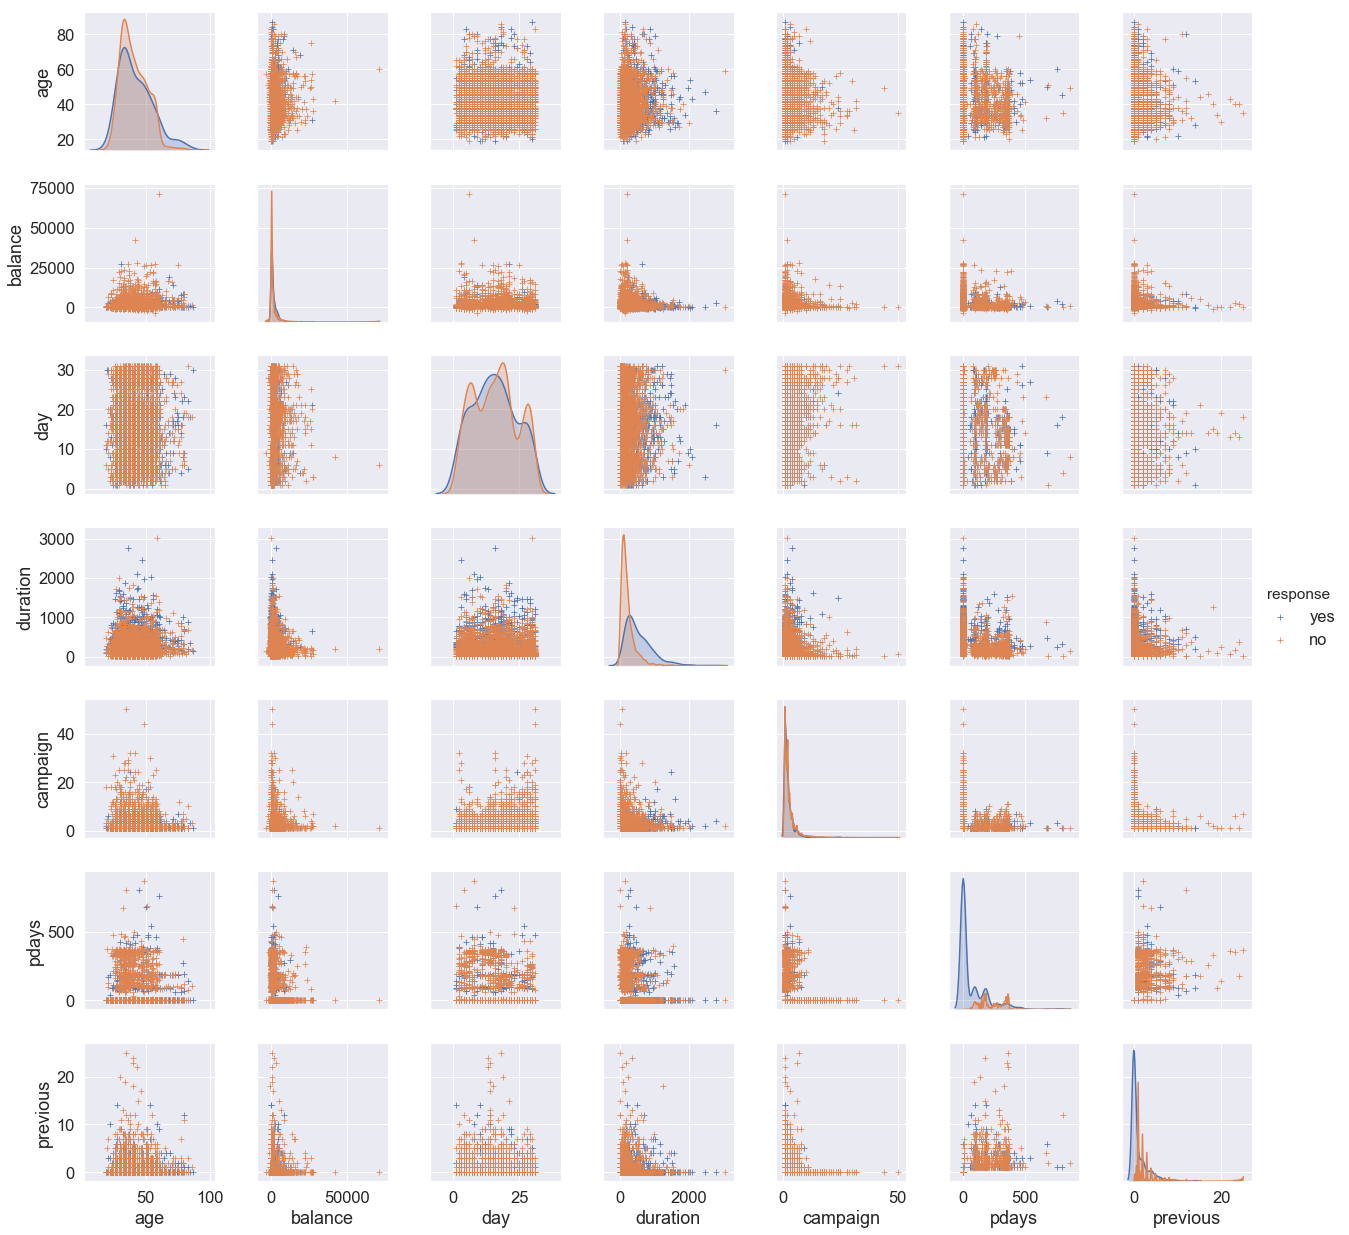

In [6]:
# let's look at the values of numerical columns first. 
# data correlation (scatterplot) and distribution (histogram or curve) by the response type (yes/no)
sns.set(font_scale = 1.5)
sns.pairplot(bank, hue='response', hue_order = ['yes', 'no'], markers = '+', height = 2.5)

There are no correlations, but we can look at the distribution and outliers of those variables. I selected some visuals and interpreted them.
* age: middle age groups such as around 30 - 45 are more likely to say no and younger, and older age groups are more likely to say yes. 
* duration: surprisingly the longer you keep the clients on the phone, the higher the chance of getting yes response 

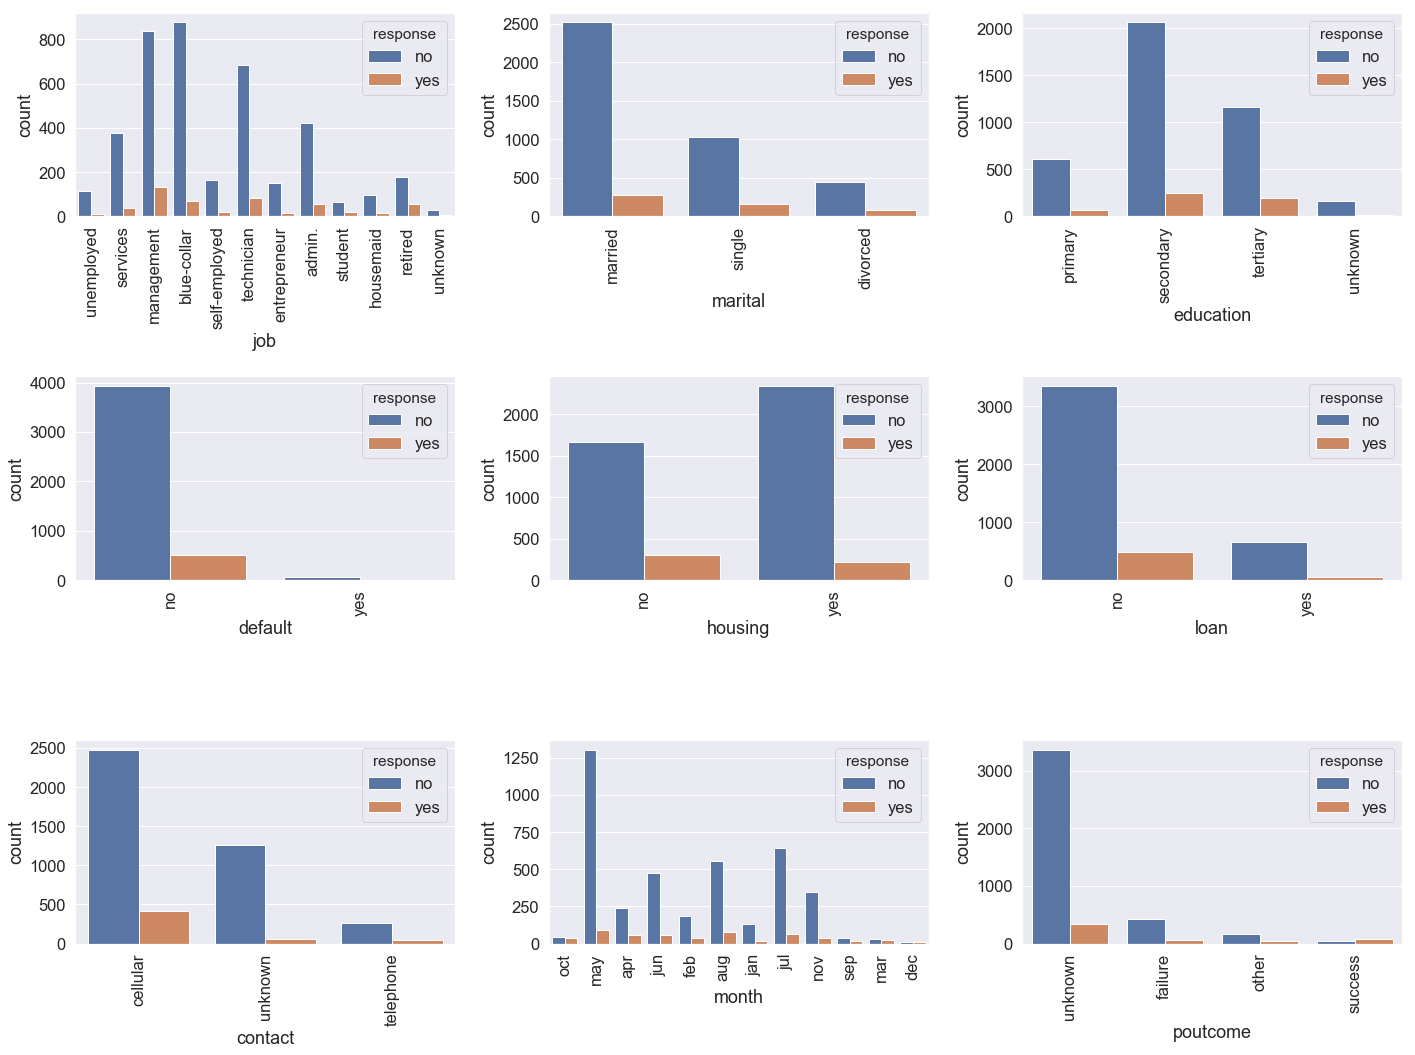

In [7]:
fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize=(20, 15))

for i, ax in zip(range(9), axes.flat):
    sns.countplot(cat_columns.iloc[:, i], hue = cat_columns.response,  ax = ax)
    plt.tight_layout(); ax.tick_params(axis ='x', rotation = 90) 
plt.show();

I selected some visuals and interpreted them.
* job level: unemployed, self-employed, entrepreneurs, students, are housemaids are not primary clients. They are few in numbers and are most likely to say no. The management, blue-collar, technicians, and admins are most likely to say yes. Retired clients have a higher percentage of saying yes. 
* marital status: most of the clients are married. 
* education level: most of the clients hold secondary education. 
* contact preferences: overall much higher chance with cell and then telephone.
* most of the clients do not have defaults and personal loans but have housing loan (mortgage).

### Data Pereperation for Modeling

In [8]:
# here we split our data into training and testing sets
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(bin_columns, test_size = 0.2, random_state = RANDOM_SEED)
## bin_columns.shape; train_set.shape; test_set.shape

X_train = train_set[['default_yes','housing_yes', 'loan_yes']].values
y_train = train_set[['response_yes']].values.ravel()
X_test = test_set[['default_yes','housing_yes', 'loan_yes']].values
y_test = test_set[['response_yes']].values.ravel()

In [9]:
# Classifier Evaluation
def clf_validation(clf, name):
    from sklearn.model_selection import cross_val_score, cross_val_predict
    from sklearn.metrics import roc_auc_score, roc_curve 
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
    
    print('\nClassifier evaluation for:', name)
    print('  Scikit Learn method:', clf)
    clf.fit(X_train, y_train)  # fit on the train set
    y_test_prob = clf.predict_proba(X_test) # evaluate on the test set
    y_test_pred = clf.predict(X_test)
    
    # Cross validation & confusion matrix
    print('cross_val_score\n',
          cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy"))
     
    print('confusion matrix:\n', confusion_matrix(y_test, y_test_pred))
    ##print('precision score: ', precision_score(y_test, y_test_pred)) # TP / (TP + FP)
    ##print('recall score: ', recall_score(y_test, y_test_pred)) # TP / (TP + FN)
    ##print('f score: ', f1_score(y_test, y_test_pred)) # 2TP / (2TP + FN + FP)
    
    #create ROC curve to validate method prediction
    auc_score = roc_auc_score(y_test, y_test_prob[:,1]) 
    print('Area under ROC curve:', auc_score)

    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob[:,1])
    ##thresholds; pd.Series(y_test_prob[:,1]).value_counts()
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label= name +' AUC (area = %0.3f)' % auc_score)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

Model data consists of three explanatory variables - default, housing, and loan - were used and one response variable -response - resulting in 4521
rows and 4 columns. 

We will measure the performance of the models using an industry standard performance metric, the ROC curve, or the Receiver Operating Characteristic curve. This metric gives us a sense for how accurate our predictions will be relative to the TPR (true positive rate) as if we dial a customer on an FPR (false-positive rate).

###  Model Exploration - Logistic Regression


Classifier evaluation for: Logistic Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
cross_val_score
 [0.88723051 0.8879668  0.8879668 ]
confusion matrix:
 [[790   0]
 [115   0]]
Area under ROC curve: 0.5974848651623555


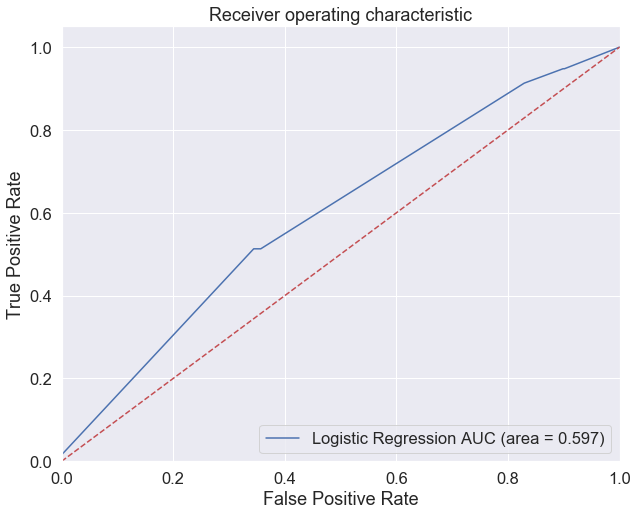

In [10]:
from sklearn.linear_model import LogisticRegression
clf_validation(clf = LogisticRegression(), name = "Logistic Regression") 

This confusion matrix shows that the 790 customers were incorrectly classified as non-responders, and 115 customers were correctly classified as responders.

###  Model Exploration - Naive Bayes


Classifier evaluation for: Naive Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
cross_val_score
 [0.88723051 0.8879668  0.8879668 ]
confusion matrix:
 [[790   0]
 [115   0]]
Area under ROC curve: 0.5974848651623555


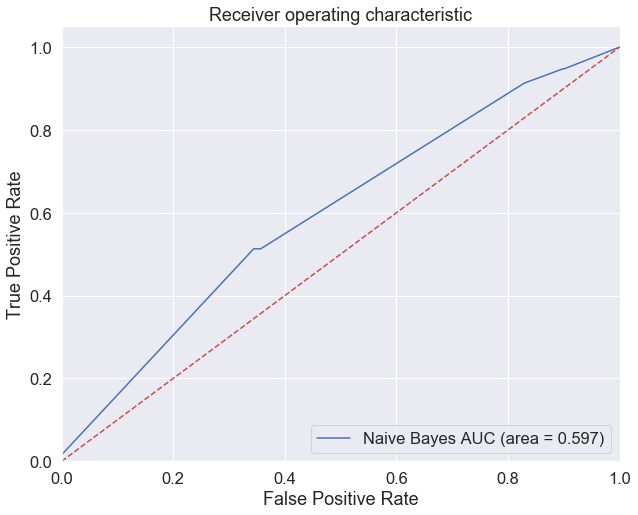

In [11]:
from sklearn.naive_bayes import BernoulliNB
#BernoulliNB(alpha=1.0, binarize=0.5, class_prior = [0.5, 0.5], fit_prior=False)
clf_validation(clf = BernoulliNB(binarize = 0.0), name = "Naive Bayes") 

Since the 88.5% (4000 out of 4521) clients have not subscribed to a term deposit, as we expected, the two classifier models predicted all response variables as 'no' response. Both models have the same or similar the area under
the receiver operating characteristic curve (ROC AUC) scores, and they are around 0.6, which is not good. 
Also, I recommend further classification models to be explored (which can take response imbalance into account) with possible more explanatory variables being introduced to help better explain an  individual's response.